In [74]:
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.constants import c
from scipy import signal

In [157]:
cfg = np.load('../../constants/config.npy', allow_pickle=True).item()
nfft = cfg['nfft']
freq = cfg['freq']
dist_vec = cfg['dist_vec']
# rbw = cfg['rbw']
rbw = 400 # kHz
nstep = freq.shape[0]

In [158]:
r = 2 # range in meters

In [159]:
t = np.arange(nstep) * 1 / (rbw * 1000)
omega = freq * 2 * np.pi

In [160]:
def simulate(motion, noise = None):
    x = motion(t)
    delta_t = 2 * (r + x) / c
    phi = np.multiply(omega, delta_t)
    iq_sample = np.exp(-1j * phi)
    if noise is not None:
        for idx in range(noise.shape[0]):
            iq_sample += noise[idx] * np.exp(-1j * omega * 2 * (dist_vec[idx]) / c)
    return x, iq_sample

def vibration(t, f_vib = 20e3, a_vib = 10e-6, phi_vib = 0):
    return a_vib * np.cos(2 * np.pi * f_vib * t + phi_vib)

def dacm(iq_sample):
    i_sample, q_sample = np.real(iq_sample), np.imag(iq_sample)
    n = i_sample.shape[0]
    d_iq = np.zeros(n-1)
    for k in range(1, n):
        d_iq[k-1] = (i_sample[k] * (q_sample[k] - q_sample[k - 1]) - q_sample[k] * (i_sample[k] - i_sample[k - 1])) / (i_sample[k] ** 2 + q_sample[k] ** 2)
    return d_iq

### Only the vibrating object: DACM works nicely

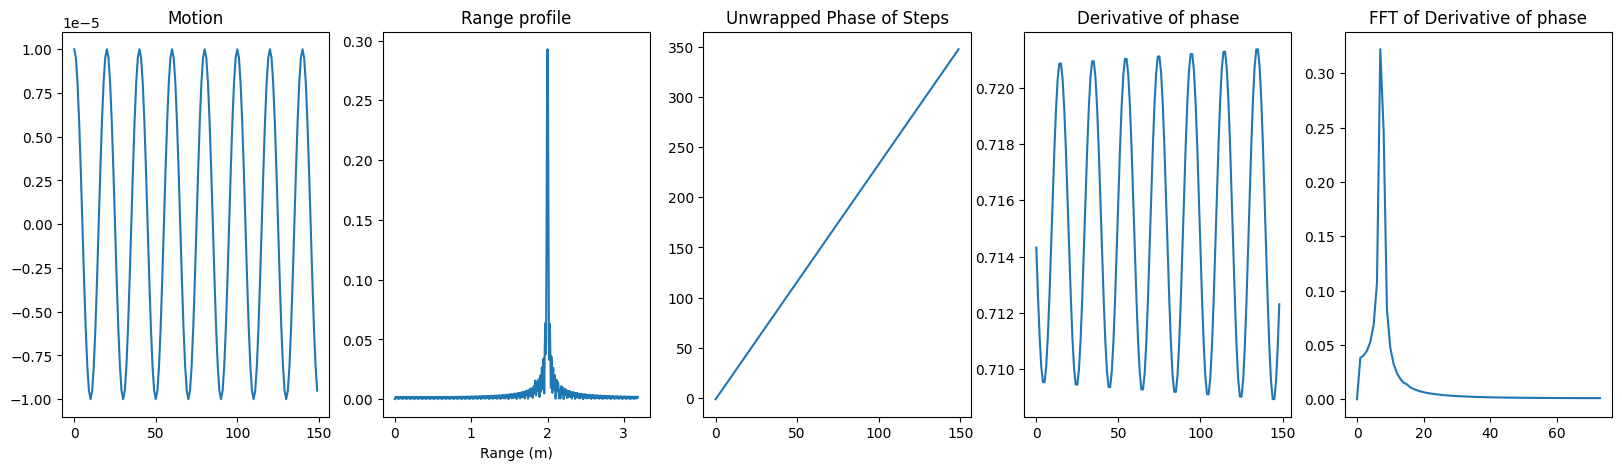

In [242]:
def plot_motion(x, iq, d_iq):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].plot(x)
    axes[0].set_title('Motion')
    # axes[1].plot(dist_vec, np.fft.ifft(iq, n=nfft))
    axes[1].plot(dist_vec, np.abs(np.fft.ifft(iq, n=nfft)))
    axes[1].set_title('Range profile')
    axes[1].set_xlabel('Range (m)')
    axes[2].plot(np.unwrap(np.angle(iq)))
    axes[2].set_title('Unwrapped Phase of Steps')
    axes[3].plot(d_iq)
    axes[3].set_title('Derivative of phase')
    # window = signal.hann(d_iq.shape[0])
    # fft_d_iq = np.fft.fft(d_iq * window)
    fft_d_iq = np.fft.fft(d_iq)
    fft_d_iq[0] = 0
    axes[4].plot(np.abs(fft_d_iq[:int(fft_d_iq.shape[0]/2)]))
    axes[4].set_title('FFT of Derivative of phase')

def plot_motion_nstep(x, iq, d_iq):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].plot(x)
    axes[0].set_title('Motion')
    # axes[1].plot(dist_vec, np.fft.ifft(iq, n=nfft))
    axes[1].plot(np.abs(np.fft.ifft(iq)))
    axes[1].set_title('Range profile')
    axes[2].plot(np.unwrap(np.angle(iq)))
    axes[2].set_title('Unwrapped Phase of Steps')
    axes[3].plot(d_iq)
    axes[3].set_title('Derivative of phase')
    # window = signal.hann(d_iq.shape[0])
    # fft_d_iq = np.fft.fft(d_iq * window)
    fft_d_iq = np.fft.fft(d_iq)
    fft_d_iq[0] = 0
    axes[4].plot(np.abs(fft_d_iq[:int(fft_d_iq.shape[0]/2)]))
    axes[4].set_title('FFT of Derivative of phase')

vib, vib_iq = simulate(vibration)
vib_d_iq = dacm(vib_iq)
plot_motion(vib, vib_iq, vib_d_iq)

### Even with a single noise object, however

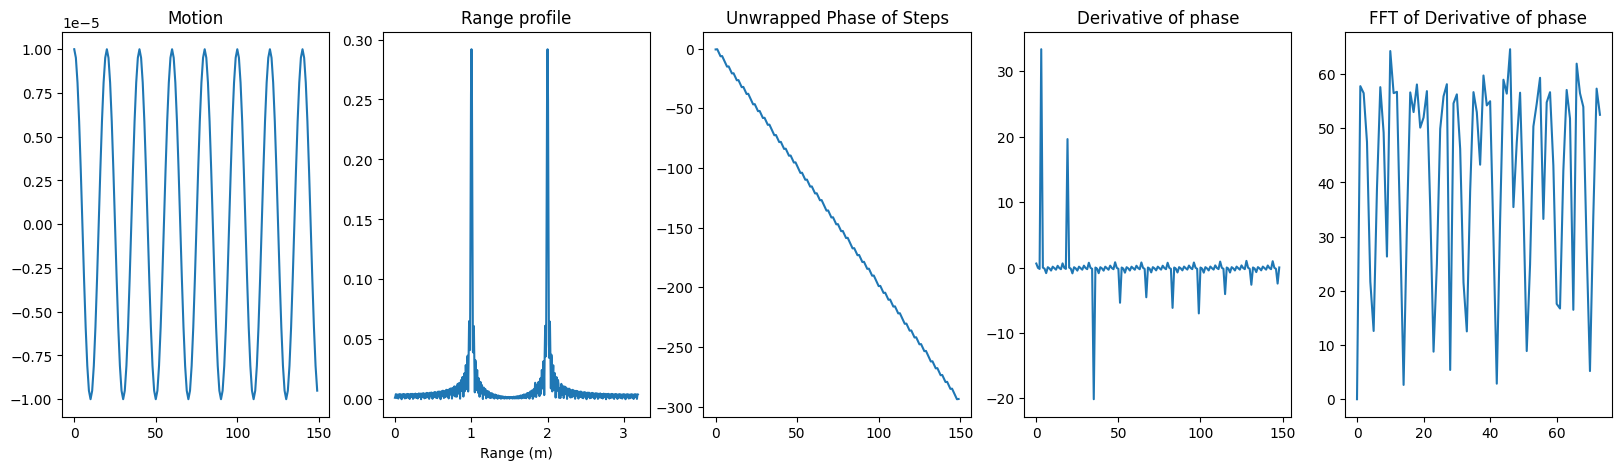

In [162]:
noise_1m = np.zeros_like(dist_vec)
noise_1m[np.argmax(dist_vec > 1)] = 1

vib_noise, vib_noise_iq = simulate(vibration, noise_1m)
vib_noise_d_iq = dacm(vib_noise_iq)
plot_motion(vib_noise, vib_noise_iq, vib_noise_d_iq)

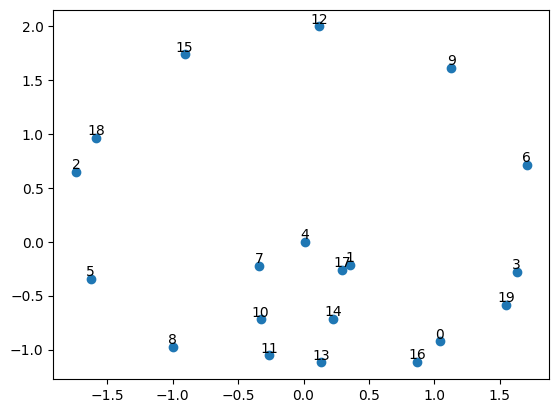

In [190]:
def plot_phasor(iq, end = None):
    if end is None:
        x, y = np.real(iq), np.imag(iq)
    else:
        x, y = np.real(iq[:end]), np.imag(iq[:end])
    plt.scatter(x, y)
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(i), ha='center', va='bottom')

plot_phasor(vib_noise_iq, end = 20) # Phasor does not contain any useful information!

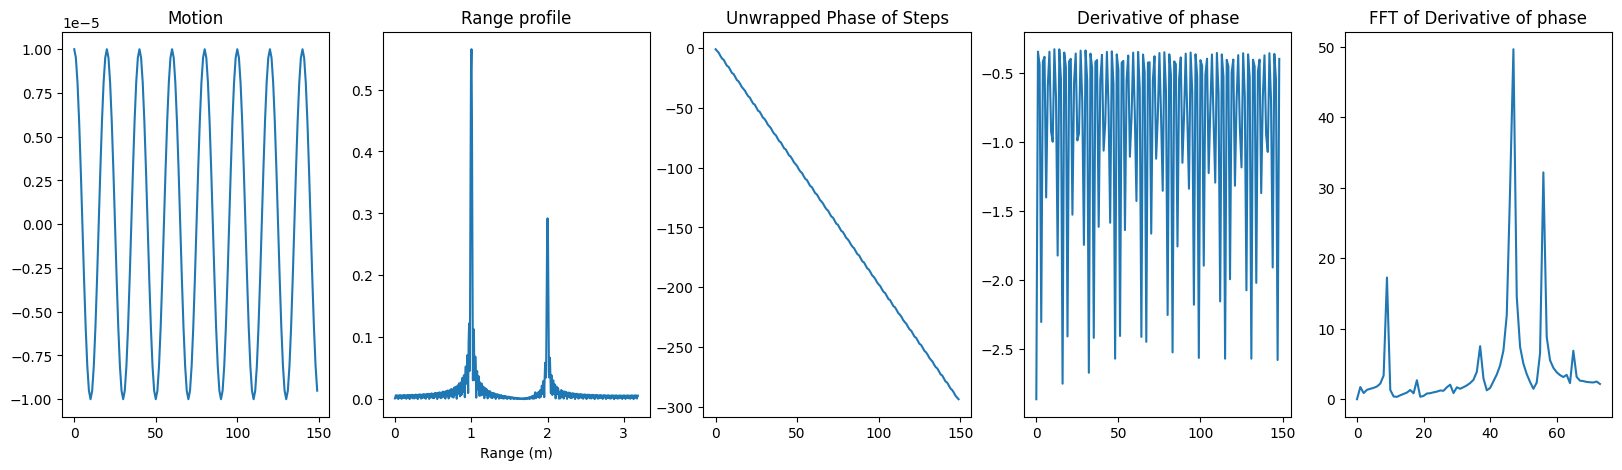

In [187]:
# Try amplitude-based denoising # ! WOULD NOT WORK IN REAL SCENARIOS because of different attenuation?

vib_noise_rp = np.fft.ifft(vib_noise_iq, n=nfft)
# vib_noise_rp[np.abs(vib_noise_rp) < 0.1] = 0
vib_denoised_iq = vib_noise_iq.copy()
# for idx in range(nfft):
#     dist = dist_vec[idx]
#     vib_denoised_iq -= np.exp(-1j * omega * 2 * dist / c) * vib_noise_rp[idx] / nstep
vib_denoised_iq -= np.exp(-1j * omega * 2 * 1 / c)

vib_denoised_d_iq = dacm(vib_denoised_iq)
plot_motion(vib_noise, vib_denoised_iq, vib_denoised_d_iq)

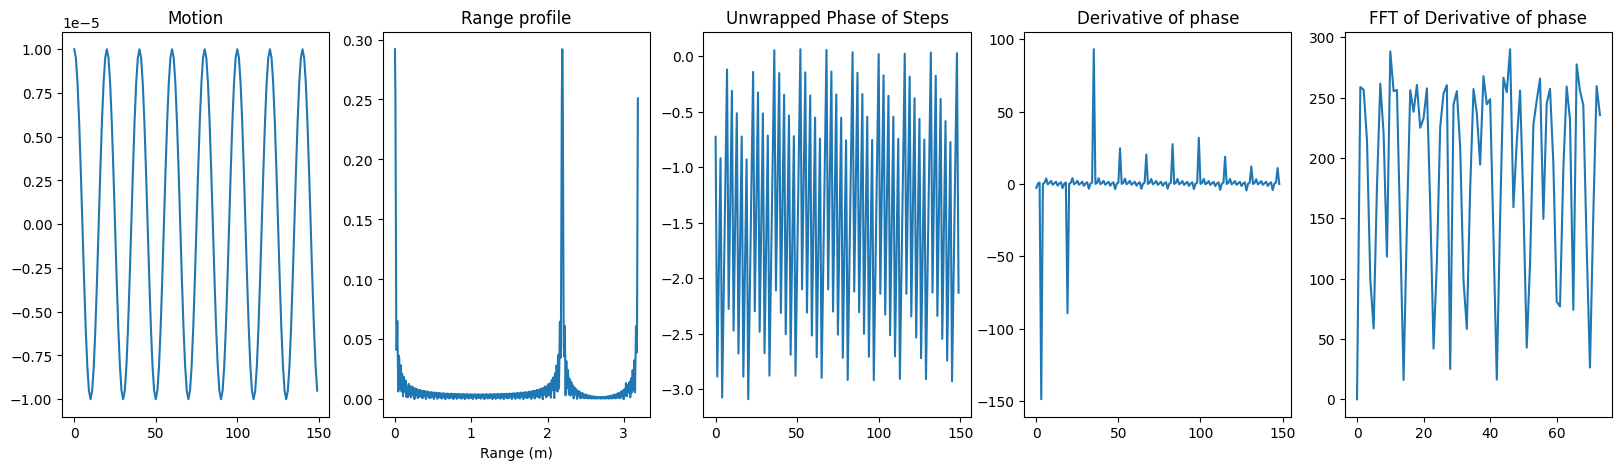

In [208]:
# # ! "Range Beamforming": only "shifts" instead of beamforms
d_omega = 2 * np.pi * (freq[1] - freq[0])
steering_vec = np.exp(1j * d_omega * np.arange(nstep) * 2 * 2 / c)
vib_beamformed_iq = vib_noise_iq * steering_vec
vib_beamformed_d_iq = dacm(vib_beamformed_iq)
plot_motion(vib_noise, vib_beamformed_iq, vib_beamformed_d_iq)

Text(0.5, 1.0, 'FFT of steps (symmetrical RP)')

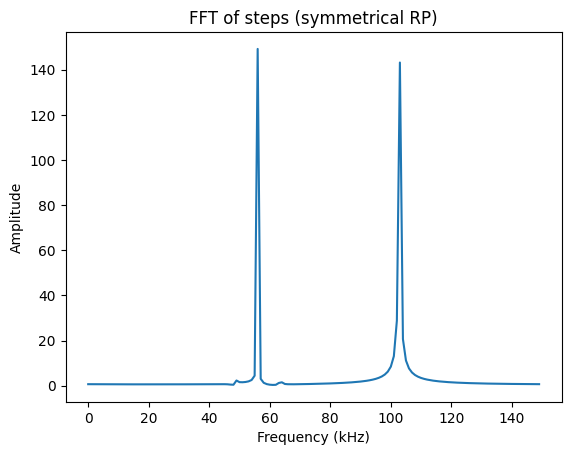

In [198]:
vib_noise_iq_fft = np.fft.fft(vib_noise_iq)
# plt.plot(np.arange(nfft) * rbw * 1e3 / nfft, np.abs(vib_noise_iq_fft))
plt.plot(np.abs(vib_noise_iq_fft))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('FFT of steps (symmetrical RP)')

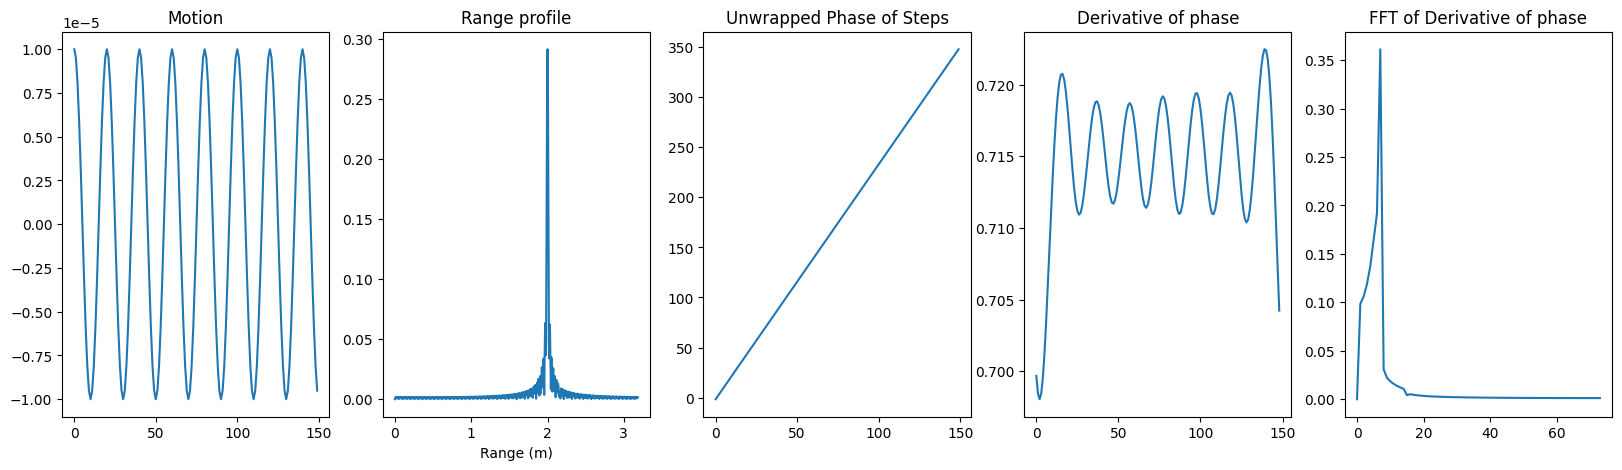

In [241]:
# # ! "Bandpass Filter" based on FFT
# target_rbin = nfft - np.argmax(dist_vec > r)
target_rbin = 55
width_rbin = 7
vib_bp_iq_fft = vib_noise_iq_fft.copy()
vib_bp_iq_fft[:target_rbin - width_rbin] = 0
vib_bp_iq_fft[target_rbin + width_rbin:] = 0
 
vib_bp_iq = np.fft.ifft(vib_bp_iq_fft)
vib_bp_d_iq = dacm(vib_bp_iq)
plot_motion(vib_noise, vib_bp_iq, vib_bp_d_iq)

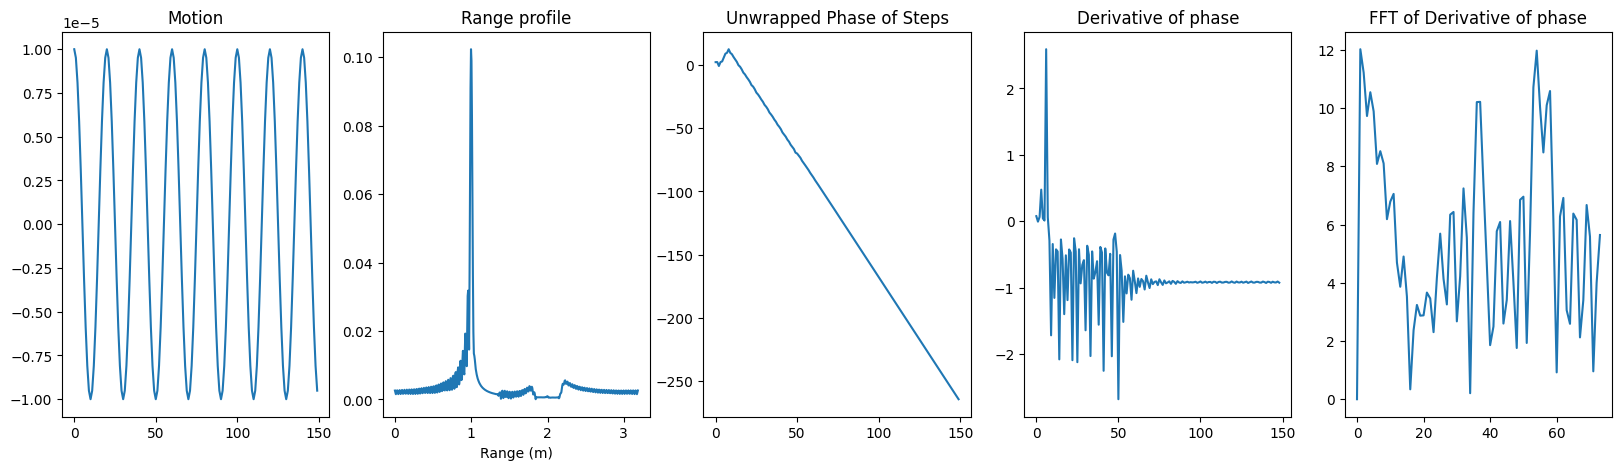

In [168]:
# # ! "Bandpass Filter" based on FIRWIN
target_rbin = nfft - np.argmax(dist_vec > r)
width_rbin = 30
start_freq, stop_freq = np.array([target_rbin - width_rbin, target_rbin + width_rbin]) * rbw * 1e3 / nfft
b = signal.firwin(101, [start_freq, stop_freq], window = 'hamming', fs = rbw * 1e3)

# vib_bp_iq = np.fft.ifft(vib_bp_iq_fft, n=nfft)
vib_bp_iq = signal.lfilter(b, 1, vib_noise_iq)
vib_bp_d_iq = dacm(vib_bp_iq)
plot_motion(vib_noise, vib_bp_iq, vib_bp_d_iq)

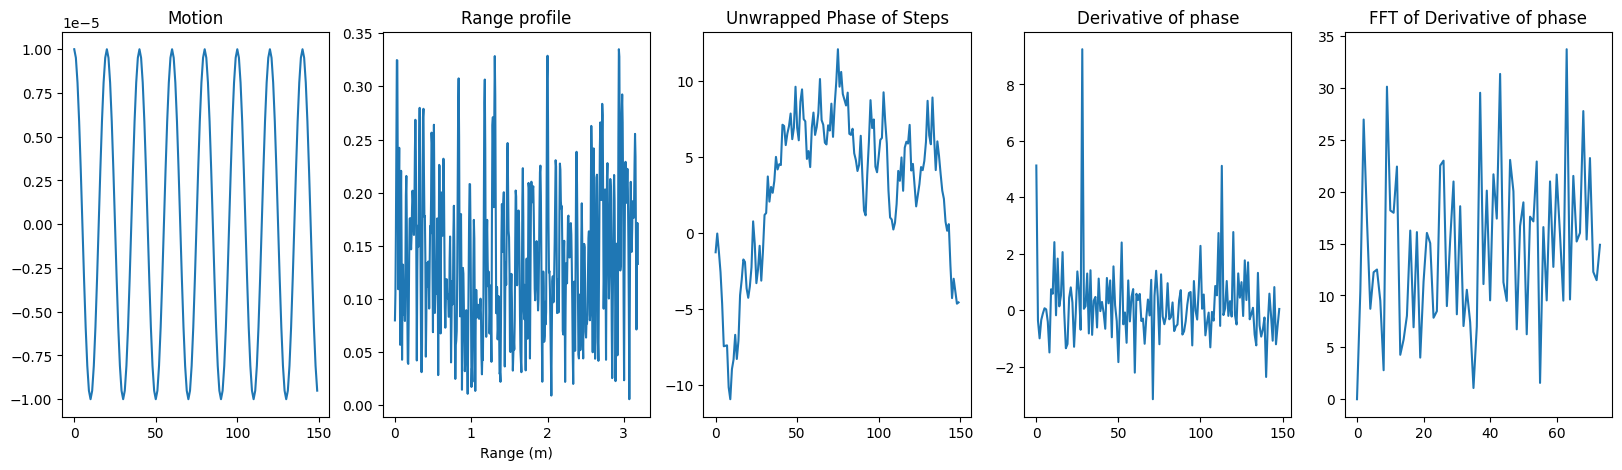

In [211]:
# # ! "Bandpass Filter" based on FFT
# target_rbin = nfft - np.argmax(dist_vec > r)
rand_noise = np.random.rand(nfft)
vib, vib_rn_iq = simulate(vibration, rand_noise)
vib_rn_d_iq = dacm(vib_rn_iq)
plot_motion(vib, vib_rn_iq, vib_rn_d_iq)

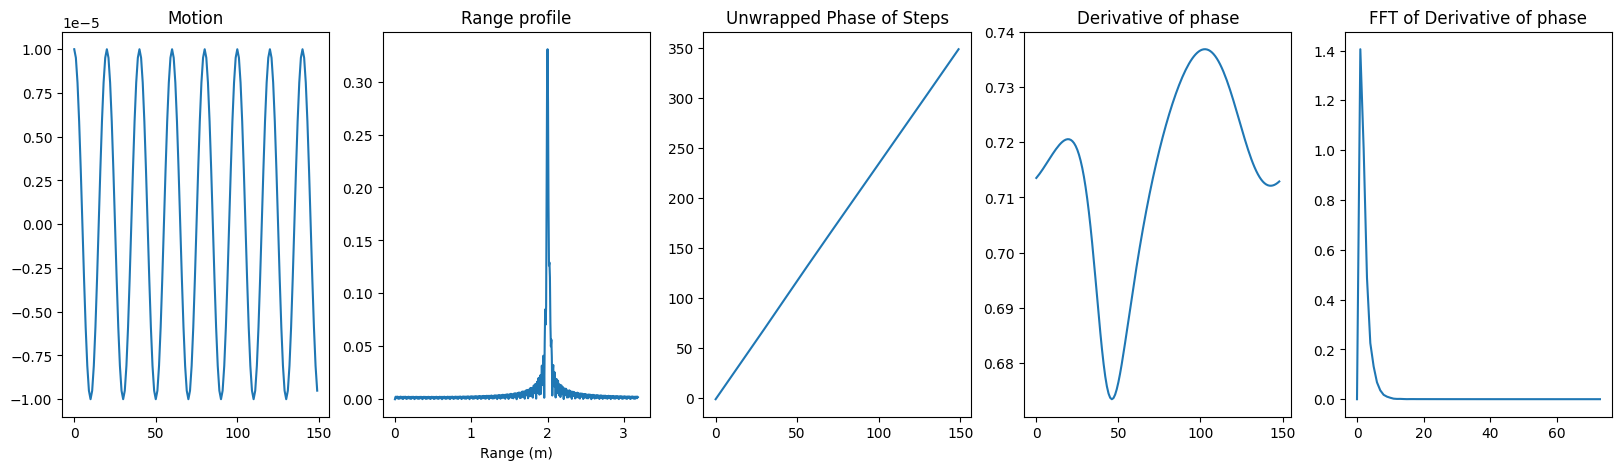

In [227]:
target_rbin = 56
width_rbin = 2
vib_rn_iq_fft = np.fft.fft(vib_rn_iq)
vib_bp_iq_fft = vib_rn_iq_fft.copy()
vib_bp_iq_fft[:target_rbin - width_rbin] = 0
vib_bp_iq_fft[target_rbin + width_rbin:] = 0
 
vib_bp_iq = np.fft.ifft(vib_bp_iq_fft)
vib_bp_d_iq = dacm(vib_bp_iq)
plot_motion(vib_noise, vib_bp_iq, vib_bp_d_iq)

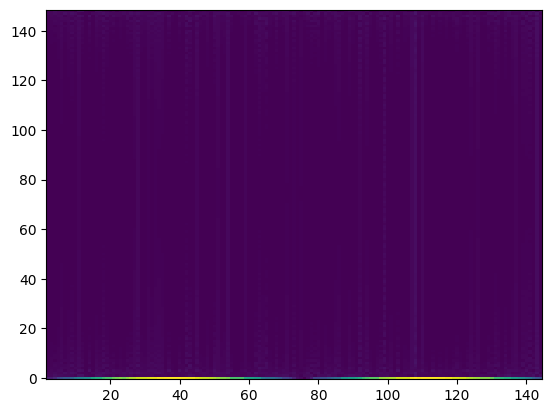

In [232]:
target_rbins = np.arange(2, 145)
fft_spectrum = np.zeros((len(target_rbins), nstep - 1))

for idx in range(len(target_rbins)):
    target_rbin = target_rbins[idx]
    width_rbin = 2
    vib_rn_iq_fft = np.fft.fft(vib_rn_iq)
    vib_bp_iq_fft = vib_rn_iq_fft.copy()
    vib_bp_iq_fft[:target_rbin - width_rbin] = 0
    vib_bp_iq_fft[target_rbin + width_rbin:] = 0
    
    vib_bp_iq = np.fft.ifft(vib_bp_iq_fft)
    vib_bp_d_iq = dacm(vib_bp_iq)
    fft_spectrum[idx, :] = np.abs(np.fft.fft(vib_bp_d_iq))

plt.pcolormesh(target_rbins, np.arange(nstep - 1), fft_spectrum.T)

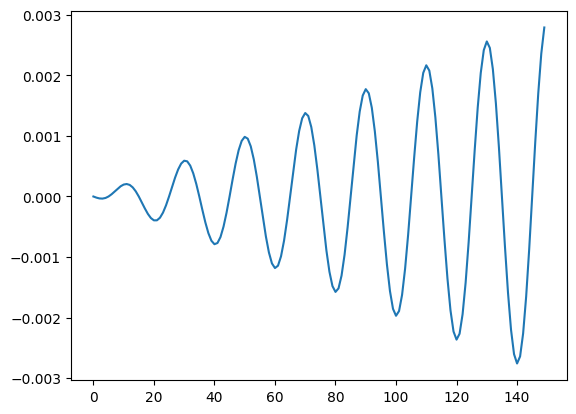

In [245]:
# # ! Correlation-based?
corr_vec = np.exp(-1j * d_omega * np.arange(nstep) * 2 * vibration(t) / c)
plt.plot(np.angle(corr_vec))

### How about chirp-based + multiplication

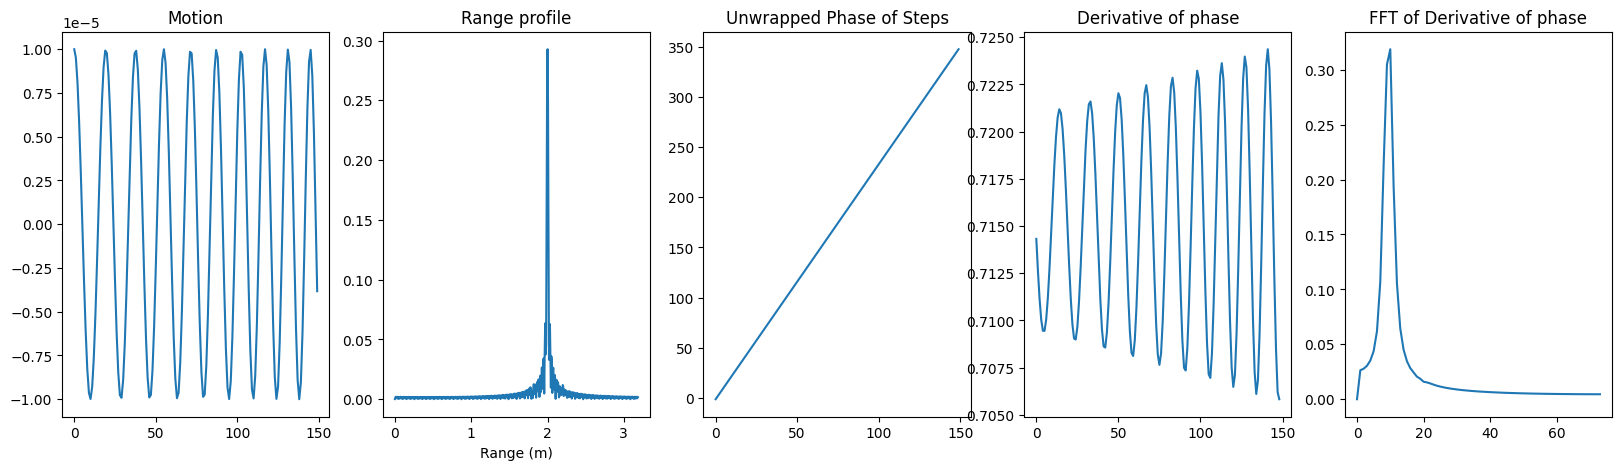

In [215]:
def chirp_gen(t, f_start = 20e3, f_stop = 23e3, a_vib = 10e-6, phi_vib = 0):
    slope = (f_stop - f_start) / (t[-1] - t[0])
    return a_vib * np.cos(2 * np.pi * (f_start + slope * t) * t + phi_vib)

chirp, chirp_iq = simulate(chirp_gen)
chirp_d_iq = dacm(chirp_iq)
plot_motion(chirp, chirp_iq, chirp_d_iq)

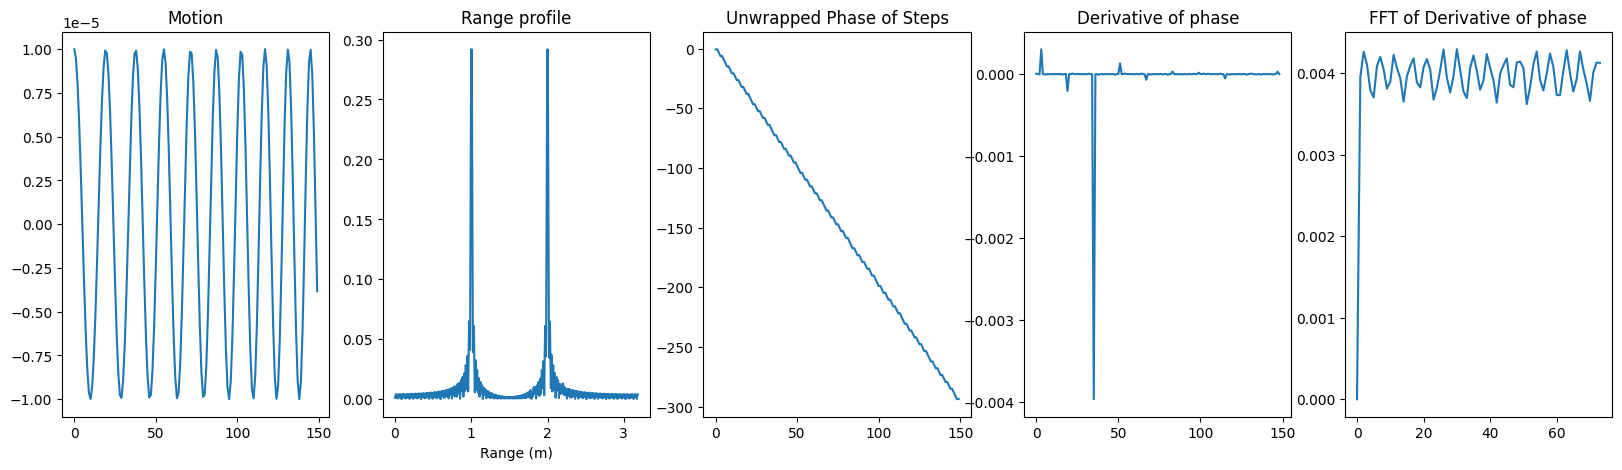

In [185]:
chirp_noise, chirp_noise_iq = simulate(chirp_gen, noise_1m)
chirp_noise_d_iq = dacm(chirp_noise_iq)
plot_motion(chirp_noise, chirp_noise_iq, chirp_noise_d_iq)

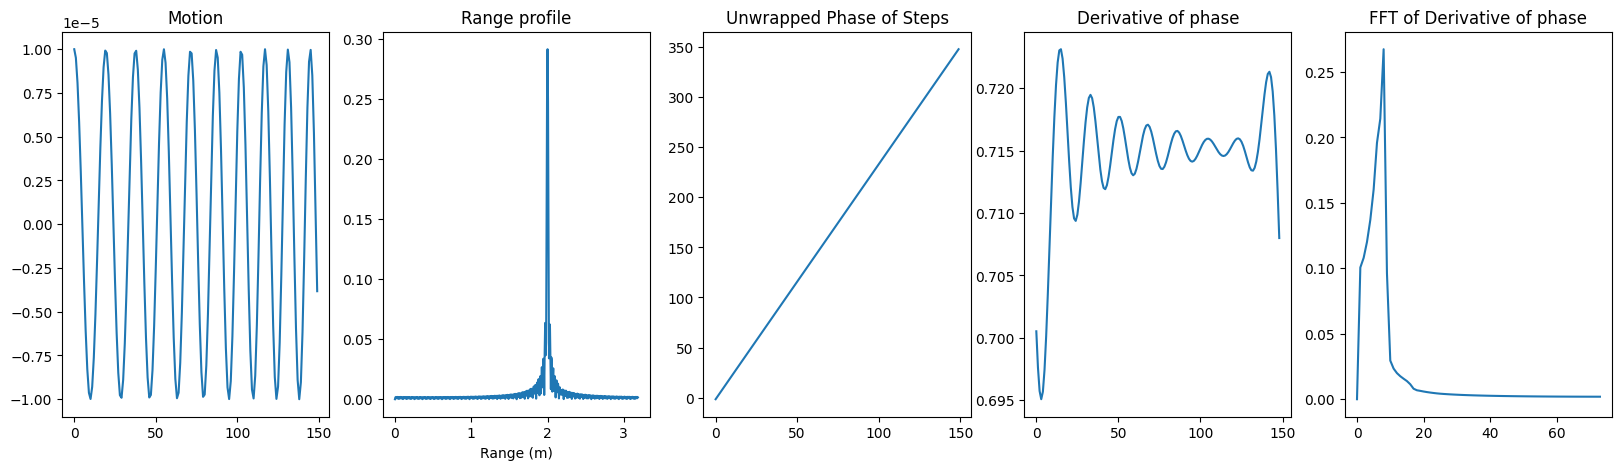

In [235]:
chirp_noise_iq_fft = np.fft.fft(chirp_noise_iq)

target_rbin = 55
width_rbin = 6
chirp_bp_iq_fft = chirp_noise_iq_fft.copy()
chirp_bp_iq_fft[:target_rbin - width_rbin] = 0
chirp_bp_iq_fft[target_rbin + width_rbin:] = 0
 
chirp_bp_iq = np.fft.ifft(chirp_bp_iq_fft)
chirp_bp_d_iq = dacm(chirp_bp_iq)
plot_motion(chirp, chirp_bp_iq, chirp_bp_d_iq)